<a href="https://colab.research.google.com/github/TitusChoi/Novelist_Classification/blob/jsy/Novelist_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import warnings 
warnings.filterwarnings(action='ignore')
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import re
import random

In [3]:
#경로 설정
import os
os.chdir('./')

In [4]:
#파일 불러오기
train = pd.read_csv('/content/drive/MyDrive/Novelist_Classification/datasets/train.csv', encoding = 'utf-8')
train_new = pd.read_csv('/content/drive/MyDrive/Novelist_Classification/datasets/new_train.csv', encoding = 'utf-8')
test = pd.read_csv('/content/drive/MyDrive/Novelist_Classification/datasets/test_x.csv', encoding = 'utf-8')
test_new = pd.read_csv('/content/drive/MyDrive/Novelist_Classification/datasets/new_test.csv', encoding = 'utf-8')
sample_submission = pd.read_csv('/content/drive/MyDrive/Novelist_Classification/datasets/sample_submission.csv', encoding = 'utf-8')
sample_submission_new = pd.read_csv('/content/drive/MyDrive/Novelist_Classification/datasets/new_sample_submission.csv', encoding = 'utf-8')

In [5]:
#train 데이터 살펴보기
train

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3
...,...,...,...
54874,54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
54875,54875,"I told my plan to the captain, and between us ...",4
54876,54876,"""Your sincere well-wisher, friend, and sister...",1
54877,54877,“Then you wanted me to lend you money?”,3


In [6]:
train_new

,Unnamed: 0,text,author
0,0,It is hard to forget repulsive things. I remem...,6
1,1,It would be tedious if given in the beadle’s w...,7
2,2,“Very good. Shall we argue about it here in p...,2
3,3,“What! and I as high as a tree and as big as a...,6
4,4,"""Isn't it enough, Vanya?"" she cried, seeing hi...",3
...,...,...,...
83215,83215,"What with the birthday visitors, and what with...",7
83216,83216,It was an old rickety door and gave at once be...,2
83217,83217,"“Well then you can go to the devil,” said odin...",3
83218,83218,“Don’t know?”,7


In [7]:
#test 데이터 살펴보기
del test_new['Unnamed: 0']
test_new

,index,text
0,0,"About thirty years ago Miss Maria Ward, of Hun..."
1,1,"Their homes were so distant, and the circles i..."
2,2,The letter was not unproductive. It re-establi...
3,3,"Such were its immediate effects, and within a ..."
4,4,Sir Thomas could not give so instantaneous and...
...,...,...
27313,27313,"At the end of another day or two, odin growing..."
27314,27314,"All afternoon we sat together, mostly in silen..."
27315,27315,"odin, having carried his thanks to odin, proc..."
27316,27316,"Soon after this, upon odin's leaving the room,..."


In [8]:
#sample_submission
del sample_submission_new['Unnamed: 0']
sample_submission_new = sample_submission_new.drop(sample_submission_new.index[27318])
sample_submission_new

,index,0,1,2,3,4,5,6,7
0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
27313,27313,0,0,0,0,0,0,0,0
27314,27314,0,0,0,0,0,0,0,0
27315,27315,0,0,0,0,0,0,0,0
27316,27316,0,0,0,0,0,0,0,0


# **전처리**

In [9]:
#부호를 제거해주는 함수
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

train['text']=train['text'].apply(alpha_num)

In [10]:
# 불용어 제거해주는 함수
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in base_stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

# 불용어
base_stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [11]:
#전처리 적용
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
train['text'] = train['text'].apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].apply(alpha_num).apply(remove_stopwords)


train_new['text'] = train_new['text'].str.lower()
test_new['text'] = test_new['text'].str.lower()
train_new['text'] = train_new['text'].apply(alpha_num).apply(remove_stopwords)
test_new['text'] = test_new['text'].apply(alpha_num).apply(remove_stopwords)

In [12]:
# train test 분리
X_train = np.array([x for x in train['text']])
X_test = np.array([x for x in test['text']])
y_train = np.array([x for x in train['author']])

X_train_new = np.array([x for x in train_new['text']])
X_test_new = np.array([x for x in test_new['text']])
y_train_new = np.array([x for x in train_new['author']])

# **모델링**

In [13]:
# FastText 사용
import gensim
from gensim.models.keyedvectors import KeyedVectors

In [14]:
pip install -U gensim

     |████████████████████████████████| 23.9MB 1.8MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [15]:
FastText = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Novelist_Classification/embbeding/fasttext.vec')

In [16]:
#파라미터 설정
vocab_size = 47136
vocab_size_new = 63727
embedding_dim = 16
max_length = 500
padding_type='post'
#oov_tok = "<OOV>"

In [17]:
#tokenizer에 fit
# 작가 5명
tokenizer = Tokenizer(num_words = vocab_size)#, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# 작가 8명
tokenizer_new = Tokenizer(num_words = vocab_size_new)#, oov_token=oov_tok)
tokenizer_new.fit_on_texts(X_train_new)
word_index_new = tokenizer_new.word_index

In [18]:
len(word_index_new)

63727

In [19]:
# Fasttext 임베딩 과정
FT_embedding_matrix = np.zeros((vocab_size,100))
FT_embedding_matrix_new = np.zeros((vocab_size_new,100))

def get_vector(word):
    if word in FastText:
        return FastText[word]
    else:
        return None

# 작가5명
for word, idx in word_index.items():
    temp = get_vector(word)
    if temp is not None:
        FT_embedding_matrix[idx] = temp

# 작가8명
for word, idx in word_index_new.items():
    temp = get_vector(word)
    if temp is not None:
        FT_embedding_matrix_new[idx] = temp

In [20]:
# 사전 학습된 glove 불러오고 임베딩 층에 적용시키기 
embedding_dict= dict()
f = open('/content/drive/MyDrive/Novelist_Classification/embbeding/glove.txt', encoding='utf8')

for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32')
    embedding_dict[word] = word_vector_arr
f.close

g_embedding_matrix = np.zeros((vocab_size, 50))
g_embedding_matrix_new = np.zeros((vocab_size_new+1, 50))

# 작가5명
for word, i in word_index.items():
    temp = embedding_dict.get(word)
    if temp is not None:
        g_embedding_matrix[i] = temp

# 작가8명
for word, i in word_index_new.items():
    temp = embedding_dict.get(word)
    if temp is not None:
        g_embedding_matrix_new[i] = temp

#CNN 모델

In [21]:
#데이터를 sequence로 변환해주고 padding 해줍니다.
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

train_sequences_new = tokenizer.texts_to_sequences(X_train_new)
train_padded_new = pad_sequences(train_sequences_new, padding=padding_type, maxlen=max_length)

test_sequences_new = tokenizer.texts_to_sequences(X_test_new)
test_padded_new = pad_sequences(test_sequences_new, padding=padding_type, maxlen=max_length)

In [22]:
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dropout,Dense, Conv1D, GlobalMaxPool1D, concatenate, MaxPool1D
import time
import matplotlib.pyplot as plt

In [23]:
# 하이퍼파라미터 설정
dropout_prob = 0.5
EMB_SIZE = 128
EPOCH = 30
VOCAB_SIZE = vocab_size
VOCAB_SIZE_new = vocab_size_new

커널 사이즈 3,4,5를 각각 거친후 GlobalMaxPool1D 실행후 concat으로 합치기<br>
FaseText 작가 5명

In [24]:
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size, 100,weights = [FT_embedding_matrix], input_length=max_length)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

In [25]:
conv1 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1 = GlobalMaxPool1D()(conv1)
conv2 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool2 = GlobalMaxPool1D()(conv2)
conv3 = Conv1D(filters=128, kernel_size=5, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool3 = GlobalMaxPool1D()(conv3)

In [26]:
# 3, 4, 5 - gram 이후 합치기
concat = concatenate([pool1, pool2, pool3])
hidden = Dense(128, activation=tf.nn.relu)(concat)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(5, name='logits')(dropout_hidden)
predictions = Dense(5, activation=tf.nn.softmax)(logits)

In [27]:
model_fast_org = Model(inputs=input_layer,outputs=predictions)
model_fast_org.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
hist_fast_org = model_fast_org.fit(train_padded,y_train,verbose=2, epochs=EPOCH,validation_split=0.2,callbacks = [early_stopping])

Epoch 1/30
1372/1372 - 82s - loss: 1.5457 - accuracy: 0.3095 - val_loss: 1.3782 - val_accuracy: 0.4078
Epoch 2/30
1372/1372 - 65s - loss: 1.2360 - accuracy: 0.4945 - val_loss: 1.0725 - val_accuracy: 0.5902
Epoch 3/30
1372/1372 - 65s - loss: 0.9224 - accuracy: 0.6497 - val_loss: 0.8786 - val_accuracy: 0.6778
Epoch 4/30
1372/1372 - 64s - loss: 0.7287 - accuracy: 0.7320 - val_loss: 0.8155 - val_accuracy: 0.6991
Epoch 5/30
1372/1372 - 64s - loss: 0.6126 - accuracy: 0.7779 - val_loss: 0.8160 - val_accuracy: 0.7080
Epoch 6/30
1372/1372 - 64s - loss: 0.5245 - accuracy: 0.8110 - val_loss: 0.8153 - val_accuracy: 0.7125
Epoch 7/30
1372/1372 - 64s - loss: 0.4691 - accuracy: 0.8295 - val_loss: 0.8499 - val_accuracy: 0.7134
Epoch 8/30
1372/1372 - 63s - loss: 0.4253 - accuracy: 0.8439 - val_loss: 0.8764 - val_accuracy: 0.7149
Epoch 9/30
1372/1372 - 63s - loss: 0.3928 - accuracy: 0.8573 - val_loss: 0.9025 - val_accuracy: 0.7170
Epoch 10/30
1372/1372 - 63s - loss: 0.3665 - accuracy: 0.8651 - val_loss:

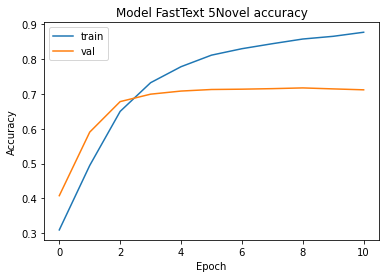

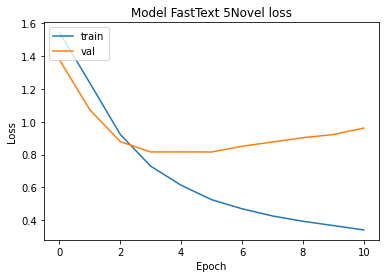

In [156]:
plt.plot(hist_fast_org.history['accuracy'])
plt.plot(hist_fast_org.history['val_accuracy'])
plt.title('Model FastText 5Novel accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_fast_org.history['loss'])
plt.plot(hist_fast_org.history['val_loss'])
plt.title('Model FastText 5Novel loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [30]:
pred_fast_org = model_fast_org.predict(test_padded)
sample_submission[['0','1','2','3','4']] = pred_fast_org
sample_submission

,index,0,1,2,3,4
0,0,2.643076e-07,7.080717e-05,9.999133e-01,1.496781e-05,6.301197e-07
1,1,1.227452e-02,2.062798e-02,3.006760e-02,9.297233e-01,7.306619e-03
2,2,9.999236e-01,6.786979e-05,1.335506e-08,3.499940e-09,8.546052e-06
3,3,2.404715e-02,1.700606e-04,6.973817e-01,2.746597e-01,3.741386e-03
4,4,9.015325e-01,4.297892e-03,4.253765e-03,8.841988e-02,1.495929e-03
...,...,...,...,...,...,...
19612,19612,3.238923e-06,9.999968e-01,9.006374e-10,2.368202e-09,2.330956e-10
19613,19613,2.544599e-06,1.839237e-07,2.153258e-08,1.309888e-13,9.999973e-01
19614,19614,3.090942e-05,9.999691e-01,2.233682e-08,5.403283e-09,4.092177e-10
19615,19615,6.126346e-09,1.000000e+00,6.187150e-13,6.610205e-15,2.819630e-15


In [31]:
model_fast_org.save('/content/drive/MyDrive/Novelist_Classification/model/CNN/cnn_fast_org.h5')


커널 사이즈 3,4,5를 각각 거친후 GlobalMaxPool1D 실행후 concat으로 합치기 <br>
FastText 작가 8명


In [32]:
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size_new, 100,weights = [FT_embedding_matrix_new], input_length=max_length)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

In [33]:
conv1 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1 = GlobalMaxPool1D()(conv1)
conv2 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool2 = GlobalMaxPool1D()(conv2)
conv3 = Conv1D(filters=128, kernel_size=5, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool3 = GlobalMaxPool1D()(conv3)

In [34]:
# 3, 4, 5 - gram 이후 합치기
concat = concatenate([pool1, pool2, pool3])
hidden = Dense(128, activation=tf.nn.relu)(concat)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(8, name='logits')(dropout_hidden)
predictions = Dense(8, activation=tf.nn.softmax)(logits)

In [35]:
model_fast_new = Model(inputs=input_layer,outputs=predictions)
model_fast_new.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [36]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
hist_fast_new = model_fast_new.fit(train_padded_new,y_train_new, epochs=EPOCH, verbose=2,validation_split=0.2,callbacks = [early_stopping])

Epoch 1/30
2081/2081 - 130s - loss: 1.9868 - accuracy: 0.2168 - val_loss: 1.6920 - val_accuracy: 0.3522
Epoch 2/30
2081/2081 - 129s - loss: 1.5603 - accuracy: 0.4053 - val_loss: 1.2979 - val_accuracy: 0.5135
Epoch 3/30
2081/2081 - 129s - loss: 1.2362 - accuracy: 0.5330 - val_loss: 1.1415 - val_accuracy: 0.5676
Epoch 4/30
2081/2081 - 129s - loss: 1.0423 - accuracy: 0.6057 - val_loss: 1.0664 - val_accuracy: 0.5928
Epoch 5/30
2081/2081 - 127s - loss: 0.9253 - accuracy: 0.6501 - val_loss: 1.0296 - val_accuracy: 0.6191
Epoch 6/30
2081/2081 - 127s - loss: 0.8364 - accuracy: 0.6800 - val_loss: 1.0280 - val_accuracy: 0.6248
Epoch 7/30
2081/2081 - 126s - loss: 0.7706 - accuracy: 0.7049 - val_loss: 0.9979 - val_accuracy: 0.6372
Epoch 8/30
2081/2081 - 126s - loss: 0.7264 - accuracy: 0.7181 - val_loss: 1.0382 - val_accuracy: 0.6182
Epoch 9/30
2081/2081 - 126s - loss: 0.6840 - accuracy: 0.7336 - val_loss: 1.0904 - val_accuracy: 0.6147
Epoch 10/30
2081/2081 - 126s - loss: 0.6530 - accuracy: 0.7425 -

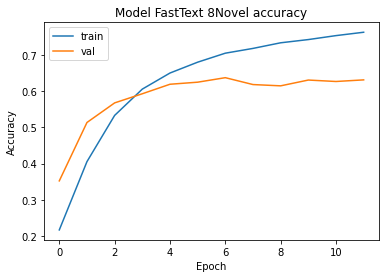

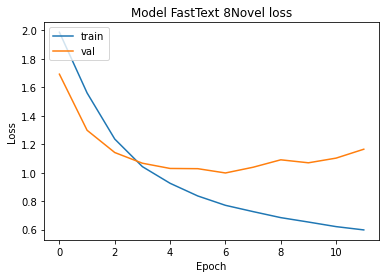

In [157]:
plt.plot(hist_fast_new.history['accuracy'])
plt.plot(hist_fast_new.history['val_accuracy'])
plt.title('Model FastText 8Novel accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_fast_new.history['loss'])
plt.plot(hist_fast_new.history['val_loss'])
plt.title('Model FastText 8Novel loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [38]:
pred_fast_new = model_fast_new.predict(test_padded_new)
sample_submission_new[['0','1','2','3','4','5','6','7']] = pred_fast_new
sample_submission_new

,index,0,1,2,3,4,5,6,7
0,0,1.660067e-09,2.153196e-01,3.452292e-07,3.982781e-08,4.391035e-10,7.846782e-01,1.701444e-06,4.018415e-08
1,1,1.159880e-05,6.064726e-01,5.901470e-02,7.813841e-03,6.348841e-05,3.114192e-01,1.515305e-02,5.174567e-05
2,2,2.688417e-07,5.133784e-02,1.070626e-07,1.749263e-07,3.748618e-09,9.486498e-01,5.208918e-06,6.566359e-06
3,3,1.223216e-06,6.182856e-02,1.352993e-06,8.501377e-07,5.710002e-08,9.380985e-01,4.326327e-05,2.620064e-05
4,4,1.683798e-02,2.597826e-05,3.343221e-06,5.737178e-07,5.740763e-05,1.422555e-03,7.708211e-03,9.739439e-01
...,...,...,...,...,...,...,...,...,...
27313,27313,3.173018e-08,9.999992e-01,1.111385e-08,8.630598e-07,6.164220e-10,4.883155e-08,2.082737e-17,2.424035e-13
27314,27314,3.004895e-07,1.114529e-14,1.203667e-05,5.643258e-12,9.936978e-01,2.245320e-15,6.281432e-03,8.478477e-06
27315,27315,5.644668e-11,9.999964e-01,2.571731e-10,4.593483e-09,1.223635e-12,3.614564e-06,7.067808e-17,1.416254e-14
27316,27316,4.883537e-04,9.993437e-01,1.764535e-05,1.401769e-04,9.592385e-06,5.206282e-07,4.187831e-13,1.387022e-08


In [39]:
model_fast_new.save('/content/drive/MyDrive/Novelist_Classification/model/CNN/cnn_fast_new.h5')

커널 사이즈 3,4,5를 각각 거친후 GlobalMaxPool1D 실행후 concat으로 합치기<br>
glove 작가 5명


In [40]:
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size, 50,weights = [g_embedding_matrix], input_length=max_length)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

In [41]:
conv1 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1 = GlobalMaxPool1D()(conv1)
conv2 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool2 = GlobalMaxPool1D()(conv2)
conv3 = Conv1D(filters=128, kernel_size=5, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool3 = GlobalMaxPool1D()(conv3)

In [42]:
# 3, 4, 5 - gram 이후 합치기
concat = concatenate([pool1, pool2, pool3])
hidden = Dense(128, activation=tf.nn.relu)(concat)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(5, name='logits')(dropout_hidden)
predictions = Dense(5, activation=tf.nn.softmax)(logits)

In [43]:
model_glove_org = Model(inputs=input_layer,outputs=predictions)
model_glove_org.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [44]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
hist_glove_org = model_glove_org.fit(train_padded,y_train, epochs=EPOCH, verbose=2,validation_split=0.2,callbacks = [early_stopping])

Epoch 1/30
1372/1372 - 36s - loss: 1.5201 - accuracy: 0.3268 - val_loss: 1.3280 - val_accuracy: 0.4455
Epoch 2/30
1372/1372 - 34s - loss: 1.3222 - accuracy: 0.4530 - val_loss: 1.1072 - val_accuracy: 0.5714
Epoch 3/30
1372/1372 - 34s - loss: 1.1739 - accuracy: 0.5309 - val_loss: 1.0081 - val_accuracy: 0.6060
Epoch 4/30
1372/1372 - 34s - loss: 1.0649 - accuracy: 0.5857 - val_loss: 0.9105 - val_accuracy: 0.6529
Epoch 5/30
1372/1372 - 34s - loss: 0.9795 - accuracy: 0.6244 - val_loss: 0.8596 - val_accuracy: 0.6771
Epoch 6/30
1372/1372 - 35s - loss: 0.9085 - accuracy: 0.6548 - val_loss: 0.8369 - val_accuracy: 0.6880
Epoch 7/30
1372/1372 - 34s - loss: 0.8529 - accuracy: 0.6817 - val_loss: 0.8005 - val_accuracy: 0.7034
Epoch 8/30
1372/1372 - 34s - loss: 0.8040 - accuracy: 0.6995 - val_loss: 0.7654 - val_accuracy: 0.7150
Epoch 9/30
1372/1372 - 35s - loss: 0.7518 - accuracy: 0.7224 - val_loss: 0.7582 - val_accuracy: 0.7223
Epoch 10/30
1372/1372 - 37s - loss: 0.7165 - accuracy: 0.7358 - val_loss:

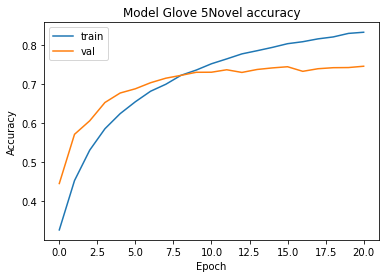

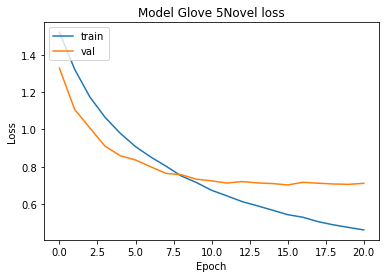

In [158]:
plt.plot(hist_glove_org.history['accuracy'])
plt.plot(hist_glove_org.history['val_accuracy'])
plt.title('Model Glove 5Novel accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_glove_org.history['loss'])
plt.plot(hist_glove_org.history['val_loss'])
plt.title('Model Glove 5Novel loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [46]:
pred_glove_org = model_glove_org.predict(test_padded)
sample_submission[['0','1','2','3','4']] = pred_glove_org
sample_submission

,index,0,1,2,3,4
0,0,0.000247,0.105264,8.913291e-01,2.866752e-03,2.935052e-04
1,1,0.273320,0.385903,5.065823e-02,2.110658e-01,7.905284e-02
2,2,0.999999,0.000001,9.459505e-10,7.091916e-09,1.726441e-07
3,3,0.000767,0.001732,9.839429e-01,1.335452e-02,2.041917e-04
4,4,0.668627,0.052500,3.184583e-02,2.025210e-01,4.450636e-02
...,...,...,...,...,...,...
19612,19612,0.000396,0.999587,9.411846e-08,1.608309e-05,8.553646e-08
19613,19613,0.001658,0.000147,1.346627e-03,2.087621e-05,9.968281e-01
19614,19614,0.000001,0.999999,4.078982e-09,2.547574e-07,8.513489e-11
19615,19615,0.000046,0.999946,6.936438e-07,7.260260e-06,3.336152e-08


In [47]:
model_glove_org.save('/content/drive/MyDrive/Novelist_Classification/model/CNN/cnn_glove_org.h5')

커널 사이즈 3,4,5를 각각 거친후 GlobalMaxPool1D 실행후 concat으로 합치기 <br>
작가 8명


In [48]:
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size_new+1, 50,weights = [g_embedding_matrix_new], input_length=max_length)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

In [49]:
conv1 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1 = GlobalMaxPool1D()(conv1)
conv2 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool2 = GlobalMaxPool1D()(conv2)
conv3 = Conv1D(filters=128, kernel_size=5, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool3 = GlobalMaxPool1D()(conv3)

In [50]:
# 3, 4, 5 - gram 이후 합치기
concat = concatenate([pool1, pool2, pool3])
hidden = Dense(128, activation=tf.nn.relu)(concat)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(8, name='logits')(dropout_hidden)
predictions = Dense(8, activation=tf.nn.softmax)(logits)

In [51]:
model_glove_new = Model(inputs=input_layer,outputs=predictions)
model_glove_new.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [52]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
hist_glove_new = model_glove_new.fit(train_padded_new,y_train_new, epochs=EPOCH, verbose=2,validation_split=0.2,callbacks = [early_stopping])

Epoch 1/30
2081/2081 - 65s - loss: 1.9410 - accuracy: 0.2220 - val_loss: 1.8150 - val_accuracy: 0.2895
Epoch 2/30
2081/2081 - 62s - loss: 1.8120 - accuracy: 0.2856 - val_loss: 1.6627 - val_accuracy: 0.3619
Epoch 3/30
2081/2081 - 61s - loss: 1.6822 - accuracy: 0.3413 - val_loss: 1.5080 - val_accuracy: 0.4374
Epoch 4/30
2081/2081 - 61s - loss: 1.5574 - accuracy: 0.3975 - val_loss: 1.3661 - val_accuracy: 0.4956
Epoch 5/30
2081/2081 - 61s - loss: 1.4567 - accuracy: 0.4421 - val_loss: 1.2874 - val_accuracy: 0.5178
Epoch 6/30
2081/2081 - 62s - loss: 1.3894 - accuracy: 0.4651 - val_loss: 1.2401 - val_accuracy: 0.5258
Epoch 7/30
2081/2081 - 61s - loss: 1.3363 - accuracy: 0.4882 - val_loss: 1.1807 - val_accuracy: 0.5573
Epoch 8/30
2081/2081 - 62s - loss: 1.2844 - accuracy: 0.5073 - val_loss: 1.1597 - val_accuracy: 0.5622
Epoch 9/30
2081/2081 - 63s - loss: 1.2404 - accuracy: 0.5211 - val_loss: 1.1451 - val_accuracy: 0.5667
Epoch 10/30
2081/2081 - 63s - loss: 1.1893 - accuracy: 0.5421 - val_loss:

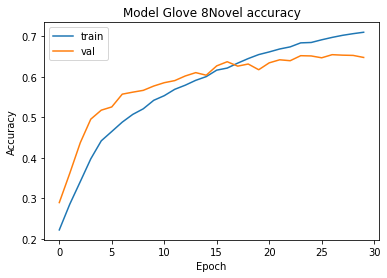

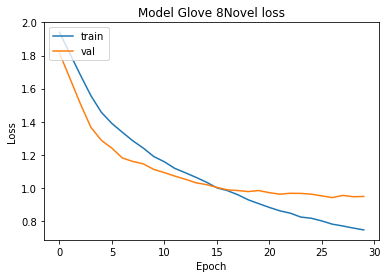

In [159]:
plt.plot(hist_glove_new.history['accuracy'])
plt.plot(hist_glove_new.history['val_accuracy'])
plt.title('Model Glove 8Novel accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_glove_new.history['loss'])
plt.plot(hist_glove_new.history['val_loss'])
plt.title('Model Glove 8Novel loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [54]:
pred_glove_new = model_glove_new.predict(test_padded_new)
sample_submission_new[['0','1','2','3','4','5','6','7']] = pred_glove_new
sample_submission_new

,index,0,1,2,3,4,5,6,7
0,0,0.000103,6.374757e-01,4.259563e-05,1.803017e-04,8.120294e-07,3.621443e-01,1.445226e-06,5.236645e-05
1,1,0.000048,1.361949e-01,1.126968e-06,1.261667e-05,4.130935e-08,8.634503e-01,7.221441e-06,2.859293e-04
2,2,0.000272,9.076676e-02,1.641013e-06,1.282083e-05,1.414887e-07,9.058434e-01,4.251874e-05,3.060344e-03
3,3,0.000030,9.032983e-02,2.273663e-07,2.602938e-06,9.629172e-09,9.092719e-01,5.860762e-06,3.591914e-04
4,4,0.010061,5.692779e-02,1.229339e-04,3.155888e-04,3.638938e-05,7.609578e-01,8.291190e-03,1.632868e-01
...,...,...,...,...,...,...,...,...,...
27313,27313,0.000007,9.999886e-01,7.920163e-08,3.729562e-06,1.133104e-09,3.040618e-07,3.051733e-18,2.866301e-11
27314,27314,0.002142,1.629217e-08,6.705129e-04,3.813934e-07,8.179168e-01,1.358860e-08,1.756284e-01,3.642051e-03
27315,27315,0.000011,9.999819e-01,3.027334e-07,6.615356e-06,4.304823e-09,6.486404e-07,3.794256e-17,7.783550e-11
27316,27316,0.000242,9.997060e-01,5.546931e-06,4.048135e-05,2.754918e-07,5.243317e-06,1.104074e-14,9.279016e-09


In [55]:
model_glove_new.save('/content/drive/MyDrive/Novelist_Classification/model/CNN/cnn_glove_new.h5')

#CNN 모델 <br>
layer 길이를 늘려보기

In [56]:
#데이터를 sequence로 변환해주고 padding 해줍니다.
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

train_sequences_new = tokenizer.texts_to_sequences(X_train_new)
train_padded_new = pad_sequences(train_sequences_new, padding=padding_type, maxlen=max_length)

test_sequences_new = tokenizer.texts_to_sequences(X_test_new)
test_padded_new = pad_sequences(test_sequences_new, padding=padding_type, maxlen=max_length)

In [57]:
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dropout,Dense, Conv1D, GlobalMaxPool1D, concatenate, MaxPool1D
import time
import matplotlib.pyplot as plt

In [58]:
# 하이퍼파라미터 설정
dropout_prob = 0.5
EMB_SIZE = 128
EPOCH = 30
VOCAB_SIZE = vocab_size
VOCAB_SIZE_new = vocab_size_new

커널 사이즈 7,6,5,4,3 의 순서로 레이어 길게 늘리기<br>
FaseText 작가 5명

In [59]:
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size, 100,weights = [FT_embedding_matrix], input_length=max_length)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

In [60]:
conv1 = Conv1D(filters=128, kernel_size=7, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1 = MaxPool1D()(conv1)
conv2 = Conv1D(filters=128, kernel_size=6, padding='valid', activation=tf.nn.relu)(pool1)
pool2 = MaxPool1D()(conv2)
conv3 = Conv1D(filters=128, kernel_size=5, padding='valid', activation=tf.nn.relu)(pool2)
pool3 = MaxPool1D()(conv3)
conv4 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(pool3)
pool4 = MaxPool1D()(conv4)
conv5 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(pool4)
pool5 = GlobalMaxPool1D()(conv5)

In [61]:
# 3, 4, 5 - gram 이후 합치기
hidden = Dense(128, activation=tf.nn.relu)(pool5)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(5, name='logits')(dropout_hidden)
predictions = Dense(5, activation=tf.nn.softmax)(logits)

In [62]:
model_fast_org_long = Model(inputs=input_layer,outputs=predictions)
model_fast_org_long.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [63]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
hist_fast_org_long = model_fast_org_long.fit(train_padded,y_train,verbose=2, epochs=EPOCH,validation_split=0.2,callbacks = [early_stopping])

Epoch 1/30
1372/1372 - 67s - loss: 1.5050 - accuracy: 0.3310 - val_loss: 1.3827 - val_accuracy: 0.3982
Epoch 2/30
1372/1372 - 63s - loss: 1.2246 - accuracy: 0.4786 - val_loss: 1.0830 - val_accuracy: 0.5606
Epoch 3/30
1372/1372 - 63s - loss: 0.9704 - accuracy: 0.6103 - val_loss: 0.9746 - val_accuracy: 0.6175
Epoch 4/30
1372/1372 - 62s - loss: 0.8013 - accuracy: 0.6933 - val_loss: 0.9007 - val_accuracy: 0.6589
Epoch 5/30
1372/1372 - 62s - loss: 0.6833 - accuracy: 0.7441 - val_loss: 0.8794 - val_accuracy: 0.6758
Epoch 6/30
1372/1372 - 62s - loss: 0.6035 - accuracy: 0.7780 - val_loss: 0.8955 - val_accuracy: 0.6803
Epoch 7/30
1372/1372 - 62s - loss: 0.5431 - accuracy: 0.7996 - val_loss: 0.9553 - val_accuracy: 0.6829
Epoch 8/30
1372/1372 - 62s - loss: 0.5024 - accuracy: 0.8164 - val_loss: 0.9141 - val_accuracy: 0.6923
Epoch 9/30
1372/1372 - 62s - loss: 0.4641 - accuracy: 0.8295 - val_loss: 1.0001 - val_accuracy: 0.6931
Epoch 10/30
1372/1372 - 62s - loss: 0.4420 - accuracy: 0.8413 - val_loss:

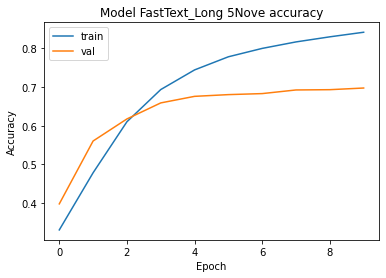

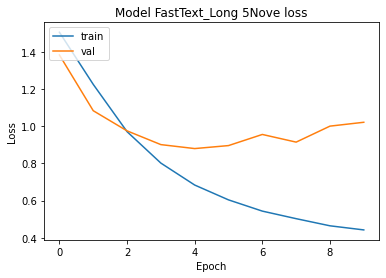

In [160]:
plt.plot(hist_fast_org_long.history['accuracy'])
plt.plot(hist_fast_org_long.history['val_accuracy'])
plt.title('Model FastText_Long 5Nove accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_fast_org_long.history['loss'])
plt.plot(hist_fast_org_long.history['val_loss'])
plt.title('Model FastText_Long 5Nove loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [65]:
pred_fast_org_long = model_fast_org_long.predict(test_padded)
sample_submission[['0','1','2','3','4']] = pred_fast_org_long
sample_submission

,index,0,1,2,3,4
0,0,1.483888e-05,6.293955e-05,9.983461e-01,4.817483e-04,1.094275e-03
1,1,2.772425e-02,3.086009e-03,3.212691e-01,4.708197e-01,1.771009e-01
2,2,9.999985e-01,1.517021e-06,1.303726e-16,2.551200e-15,4.162578e-11
3,3,5.123718e-09,4.520864e-09,9.761595e-01,2.382482e-02,1.576239e-05
4,4,3.427707e-01,1.764468e-01,1.805400e-01,1.253234e-01,1.749190e-01
...,...,...,...,...,...,...
19612,19612,1.655271e-12,1.000000e+00,4.611420e-19,8.024340e-19,6.016246e-24
19613,19613,7.905643e-08,1.390475e-14,1.146007e-07,2.934090e-14,9.999998e-01
19614,19614,3.901334e-07,9.999996e-01,1.424079e-10,8.454951e-11,2.513781e-13
19615,19615,2.656801e-09,1.000000e+00,1.764071e-13,4.689175e-13,3.429090e-17


In [66]:
model_fast_org_long.save('/content/drive/MyDrive/Novelist_Classification/model/CNN/cnn_fast_org_long.h5')


커널 사이즈 3,4,5를 각각 거친후 GlobalMaxPool1D 실행후 concat으로 합치기 <br>
FastText 작가 8명


In [67]:
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size_new, 100,weights = [FT_embedding_matrix_new], input_length=max_length)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

In [68]:
conv1 = Conv1D(filters=128, kernel_size=7, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1 = MaxPool1D()(conv1)
conv2 = Conv1D(filters=128, kernel_size=6, padding='valid', activation=tf.nn.relu)(pool1)
pool2 = MaxPool1D()(conv2)
conv3 = Conv1D(filters=128, kernel_size=5, padding='valid', activation=tf.nn.relu)(pool2)
pool3 = MaxPool1D()(conv3)
conv4 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(pool3)
pool4 = MaxPool1D()(conv4)
conv5 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(pool4)
pool5 = GlobalMaxPool1D()(conv5)

In [69]:

hidden = Dense(128, activation=tf.nn.relu)(pool5)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(8, name='logits')(dropout_hidden)
predictions = Dense(8, activation=tf.nn.softmax)(logits)

In [70]:
model_fast_new_long = Model(inputs=input_layer,outputs=predictions)
model_fast_new_long.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [71]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
hist_fast_new_long = model_fast_new_long.fit(train_padded_new,y_train_new, epochs=EPOCH, verbose=2,validation_split=0.2,callbacks = [early_stopping])

Epoch 1/30
2081/2081 - 130s - loss: 1.8575 - accuracy: 0.2652 - val_loss: 1.5121 - val_accuracy: 0.4152
Epoch 2/30
2081/2081 - 129s - loss: 1.4377 - accuracy: 0.4395 - val_loss: 1.3188 - val_accuracy: 0.4816
Epoch 3/30
2081/2081 - 130s - loss: 1.2671 - accuracy: 0.5009 - val_loss: 1.2323 - val_accuracy: 0.5168
Epoch 4/30
2081/2081 - 130s - loss: 1.1616 - accuracy: 0.5404 - val_loss: 1.1987 - val_accuracy: 0.5395
Epoch 5/30
2081/2081 - 130s - loss: 1.0735 - accuracy: 0.5755 - val_loss: 1.1493 - val_accuracy: 0.5598
Epoch 6/30
2081/2081 - 130s - loss: 1.0017 - accuracy: 0.6044 - val_loss: 1.1376 - val_accuracy: 0.5598
Epoch 7/30
2081/2081 - 130s - loss: 0.9350 - accuracy: 0.6333 - val_loss: 1.1234 - val_accuracy: 0.5868
Epoch 8/30
2081/2081 - 130s - loss: 0.8774 - accuracy: 0.6548 - val_loss: 1.1860 - val_accuracy: 0.5902
Epoch 9/30
2081/2081 - 130s - loss: 0.8310 - accuracy: 0.6710 - val_loss: 1.1115 - val_accuracy: 0.6000
Epoch 10/30
2081/2081 - 130s - loss: 0.7925 - accuracy: 0.6895 -

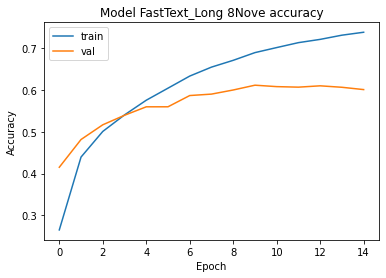

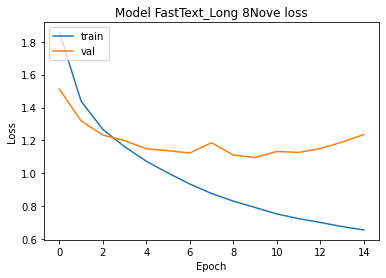

In [161]:
plt.plot(hist_fast_new_long.history['accuracy'])
plt.plot(hist_fast_new_long.history['val_accuracy'])
plt.title('Model FastText_Long 8Nove accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_fast_new_long.history['loss'])
plt.plot(hist_fast_new_long.history['val_loss'])
plt.title('Model FastText_Long 8Nove loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [73]:
pred_fast_new_long = model_fast_new_long.predict(test_padded_new)
sample_submission_new[['0','1','2','3','4','5','6','7']] = pred_fast_new_long
sample_submission_new

,index,0,1,2,3,4,5,6,7
0,0,4.633769e-10,0.010984,3.628380e-16,9.517124e-15,1.567928e-16,9.890162e-01,2.275837e-16,5.483754e-09
1,1,3.910306e-06,0.568892,5.973572e-05,1.820542e-06,9.188309e-07,4.310390e-01,3.247695e-08,2.235172e-06
2,2,1.463654e-05,0.098668,2.008730e-08,7.299592e-08,6.075129e-09,9.012708e-01,9.761578e-09,4.665081e-05
3,3,9.555998e-06,0.043920,2.939748e-11,9.332154e-11,4.151676e-11,9.560161e-01,1.673268e-11,5.387333e-05
4,4,5.280179e-02,0.034453,6.851044e-06,1.835565e-05,2.184708e-05,4.815996e-01,5.123008e-05,4.310475e-01
...,...,...,...,...,...,...,...,...,...
27313,27313,3.255262e-12,1.000000,6.051827e-18,1.389399e-18,1.590112e-18,8.318602e-11,0.000000e+00,5.432698e-23
27314,27314,4.386721e-01,0.000135,5.905858e-03,1.129433e-04,3.613884e-01,2.277038e-05,6.182184e-03,1.875803e-01
27315,27315,3.985209e-07,0.999999,3.797560e-09,6.683575e-09,8.396390e-10,3.794110e-07,4.639287e-22,6.549787e-14
27316,27316,1.049728e-04,0.999696,9.879309e-07,1.789178e-06,2.968353e-07,1.961650e-04,1.128263e-14,1.092049e-08


In [74]:
model_fast_new_long.save('/content/drive/MyDrive/Novelist_Classification/model/CNN/cnn_fast_new_long.h5')

커널 사이즈 3,4,5를 각각 거친후 GlobalMaxPool1D 실행후 concat으로 합치기<br>
glove 작가 5명


In [75]:
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size, 50,weights = [g_embedding_matrix], input_length=max_length)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

In [76]:
conv1 = Conv1D(filters=128, kernel_size=7, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1 = MaxPool1D()(conv1)
conv2 = Conv1D(filters=128, kernel_size=6, padding='valid', activation=tf.nn.relu)(pool1)
pool2 = MaxPool1D()(conv2)
conv3 = Conv1D(filters=128, kernel_size=5, padding='valid', activation=tf.nn.relu)(pool2)
pool3 = MaxPool1D()(conv3)
conv4 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(pool3)
pool4 = MaxPool1D()(conv4)
conv5 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(pool4)
pool5 = GlobalMaxPool1D()(conv5)

In [77]:

hidden = Dense(128, activation=tf.nn.relu)(pool5)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(5, name='logits')(dropout_hidden)
predictions = Dense(5, activation=tf.nn.softmax)(logits)

In [78]:
model_glove_org_long = Model(inputs=input_layer,outputs=predictions)
model_glove_org_long.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [79]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
hist_glove_org_long = model_glove_org_long.fit(train_padded,y_train, epochs=EPOCH, verbose=2,validation_split=0.2,callbacks = [early_stopping])

Epoch 1/30
1372/1372 - 36s - loss: 1.4675 - accuracy: 0.3421 - val_loss: 1.3408 - val_accuracy: 0.4339
Epoch 2/30
1372/1372 - 35s - loss: 1.2529 - accuracy: 0.4802 - val_loss: 1.1276 - val_accuracy: 0.5415
Epoch 3/30
1372/1372 - 34s - loss: 1.0917 - accuracy: 0.5584 - val_loss: 0.9925 - val_accuracy: 0.6068
Epoch 4/30
1372/1372 - 34s - loss: 0.9930 - accuracy: 0.6055 - val_loss: 0.9511 - val_accuracy: 0.6297
Epoch 5/30
1372/1372 - 35s - loss: 0.9170 - accuracy: 0.6436 - val_loss: 0.8961 - val_accuracy: 0.6550
Epoch 6/30
1372/1372 - 34s - loss: 0.8445 - accuracy: 0.6771 - val_loss: 0.8433 - val_accuracy: 0.6826
Epoch 7/30
1372/1372 - 34s - loss: 0.7978 - accuracy: 0.6988 - val_loss: 0.8565 - val_accuracy: 0.6784
Epoch 8/30
1372/1372 - 34s - loss: 0.7525 - accuracy: 0.7186 - val_loss: 0.8464 - val_accuracy: 0.6813
Epoch 9/30
1372/1372 - 34s - loss: 0.7119 - accuracy: 0.7351 - val_loss: 0.7949 - val_accuracy: 0.7065
Epoch 10/30
1372/1372 - 34s - loss: 0.6798 - accuracy: 0.7474 - val_loss:

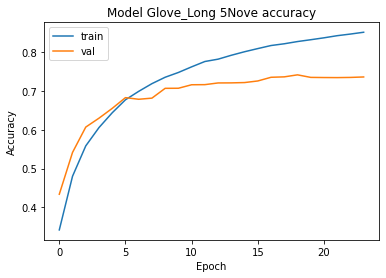

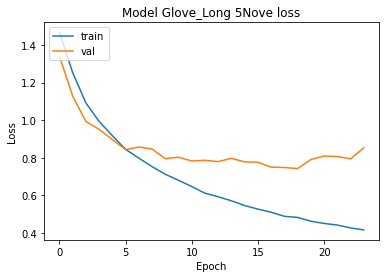

In [162]:
plt.plot(hist_glove_org_long.history['accuracy'])
plt.plot(hist_glove_org_long.history['val_accuracy'])
plt.title('Model Glove_Long 5Nove accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_glove_org_long.history['loss'])
plt.plot(hist_glove_org_long.history['val_loss'])
plt.title('Model Glove_Long 5Nove loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [81]:
pred_glove_org_long = model_glove_org_long.predict(test_padded)
sample_submission[['0','1','2','3','4']] = pred_glove_org_long
sample_submission

,index,0,1,2,3,4
0,0,1.504621e-03,7.954248e-01,1.959944e-01,6.905654e-03,1.704722e-04
1,1,4.898875e-01,2.280823e-01,1.090052e-01,4.752301e-02,1.255019e-01
2,2,1.000000e+00,4.528381e-08,2.499825e-17,3.806593e-12,6.808089e-12
3,3,4.827359e-08,1.564394e-05,9.996443e-01,2.428824e-06,3.376153e-04
4,4,9.862936e-01,6.449004e-03,1.454330e-04,4.129281e-03,2.982802e-03
...,...,...,...,...,...,...
19612,19612,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
19613,19613,3.351962e-05,4.204875e-09,3.095794e-05,5.141162e-09,9.999355e-01
19614,19614,2.989242e-12,1.000000e+00,1.960836e-14,3.441768e-14,1.813983e-20
19615,19615,3.296693e-17,1.000000e+00,2.235299e-22,2.947778e-21,1.190369e-30


In [82]:
model_glove_org_long.save('/content/drive/MyDrive/Novelist_Classification/model/CNN/cnn_glove_org_long.h5')

커널 사이즈 3,4,5를 각각 거친후 GlobalMaxPool1D 실행후 concat으로 합치기 <br>
작가 8명


In [83]:
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size_new+1, 50,weights = [g_embedding_matrix_new], input_length=max_length)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

In [84]:
conv1 = Conv1D(filters=128, kernel_size=7, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1 = MaxPool1D()(conv1)
conv2 = Conv1D(filters=128, kernel_size=6, padding='valid', activation=tf.nn.relu)(pool1)
pool2 = MaxPool1D()(conv2)
conv3 = Conv1D(filters=128, kernel_size=5, padding='valid', activation=tf.nn.relu)(pool2)
pool3 = MaxPool1D()(conv3)
conv4 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(pool3)
pool4 = MaxPool1D()(conv4)
conv5 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(pool4)
pool5 = GlobalMaxPool1D()(conv5)

In [85]:
hidden = Dense(128, activation=tf.nn.relu)(pool5)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(8, name='logits')(dropout_hidden)
predictions = Dense(8, activation=tf.nn.softmax)(logits)

In [86]:
model_glove_new_long = Model(inputs=input_layer,outputs=predictions)
model_glove_new_long.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [87]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
hist_glove_new_long = model_glove_new_long.fit(train_padded_new,y_train_new, epochs=EPOCH, verbose=2,validation_split=0.2,callbacks = [early_stopping])

Epoch 1/30
2081/2081 - 63s - loss: 1.9009 - accuracy: 0.2321 - val_loss: 1.7951 - val_accuracy: 0.2770
Epoch 2/30
2081/2081 - 62s - loss: 1.7072 - accuracy: 0.3289 - val_loss: 1.5816 - val_accuracy: 0.3805
Epoch 3/30
2081/2081 - 62s - loss: 1.5510 - accuracy: 0.3992 - val_loss: 1.4402 - val_accuracy: 0.4438
Epoch 4/30
2081/2081 - 62s - loss: 1.4202 - accuracy: 0.4542 - val_loss: 1.3583 - val_accuracy: 0.4785
Epoch 5/30
2081/2081 - 63s - loss: 1.3168 - accuracy: 0.4945 - val_loss: 1.2527 - val_accuracy: 0.5129
Epoch 6/30
2081/2081 - 62s - loss: 1.2381 - accuracy: 0.5221 - val_loss: 1.1780 - val_accuracy: 0.5478
Epoch 7/30
2081/2081 - 62s - loss: 1.1746 - accuracy: 0.5474 - val_loss: 1.2274 - val_accuracy: 0.5310
Epoch 8/30
2081/2081 - 62s - loss: 1.1195 - accuracy: 0.5634 - val_loss: 1.1072 - val_accuracy: 0.5705
Epoch 9/30
2081/2081 - 62s - loss: 1.0759 - accuracy: 0.5804 - val_loss: 1.0834 - val_accuracy: 0.5816
Epoch 10/30
2081/2081 - 63s - loss: 1.0343 - accuracy: 0.5976 - val_loss:

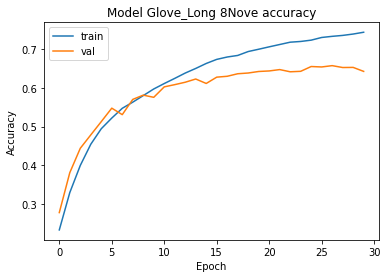

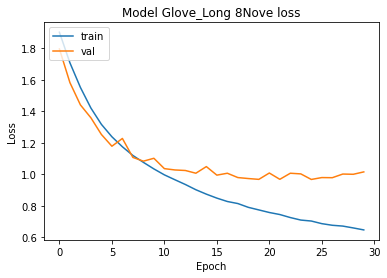

In [163]:
plt.plot(hist_glove_new_long.history['accuracy'])
plt.plot(hist_glove_new_long.history['val_accuracy'])
plt.title('Model Glove_Long 8Nove accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_glove_new_long.history['loss'])
plt.plot(hist_glove_new_long.history['val_loss'])
plt.title('Model Glove_Long 8Nove loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [89]:
pred_glove_new_long = model_glove_new_long.predict(test_padded_new)
sample_submission_new[['0','1','2','3','4','5','6','7']] = pred_glove_new_long
sample_submission_new

,index,0,1,2,3,4,5,6,7
0,0,9.152864e-12,0.005084,4.234708e-13,6.304905e-14,1.368433e-16,9.949163e-01,1.276993e-12,1.340284e-10
1,1,5.813179e-07,0.023734,7.489608e-06,7.905161e-09,1.264934e-08,9.762393e-01,7.200347e-07,1.784321e-05
2,2,4.307517e-04,0.020669,1.216004e-05,2.528166e-06,3.840430e-07,9.700342e-01,2.567995e-05,8.825606e-03
3,3,4.250509e-08,0.003994,5.623144e-11,6.854806e-11,5.077022e-13,9.960048e-01,3.887544e-10,1.224811e-06
4,4,1.198655e-05,0.020273,3.784083e-07,1.121552e-07,6.220593e-09,9.795558e-01,1.986496e-06,1.572269e-04
...,...,...,...,...,...,...,...,...,...
27313,27313,4.348725e-38,1.000000,1.985099e-30,4.451045e-27,0.000000e+00,2.335529e-18,0.000000e+00,0.000000e+00
27314,27314,2.020397e-01,0.000248,4.744900e-03,3.505134e-05,6.804056e-01,4.482737e-05,5.927656e-05,1.124223e-01
27315,27315,4.343117e-07,0.999999,2.736805e-08,1.042393e-07,2.773510e-09,2.798925e-11,1.360062e-20,1.430062e-17
27316,27316,1.373719e-08,1.000000,8.621227e-09,2.532093e-08,1.310138e-10,1.426665e-10,2.382109e-20,1.785358e-18


In [90]:
model_glove_new_long.save('/content/drive/MyDrive/Novelist_Classification/model/CNN/cnn_glove_new_long.h5')

#CNN 모델<br>
layer 7,6,5,4,3 으로 넓게

In [91]:
#데이터를 sequence로 변환해주고 padding 해줍니다.
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

train_sequences_new = tokenizer.texts_to_sequences(X_train_new)
train_padded_new = pad_sequences(train_sequences_new, padding=padding_type, maxlen=max_length)

test_sequences_new = tokenizer.texts_to_sequences(X_test_new)
test_padded_new = pad_sequences(test_sequences_new, padding=padding_type, maxlen=max_length)

In [92]:
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dropout,Dense, Conv1D, GlobalMaxPool1D, concatenate, MaxPool1D
import time
import matplotlib.pyplot as plt

In [93]:
# 하이퍼파라미터 설정
dropout_prob = 0.5
EMB_SIZE = 128
EPOCH = 30
VOCAB_SIZE = vocab_size
VOCAB_SIZE_new = vocab_size_new

커널 사이즈 3,4,5를 각각 거친후 GlobalMaxPool1D 실행후 concat으로 합치기<br>
FaseText 작가 5명

In [94]:
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size, 100,weights = [FT_embedding_matrix], input_length=max_length)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

In [95]:
conv1_1 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1_1 = GlobalMaxPool1D()(conv1_1)
conv1_2 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1_2 = GlobalMaxPool1D()(conv1_2)
conv2_1 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool2_1 = GlobalMaxPool1D()(conv2_1)
conv2_2 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool2_2 = GlobalMaxPool1D()(conv2_2)
conv3_1 = Conv1D(filters=128, kernel_size=2, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool3_1 = GlobalMaxPool1D()(conv3_1)
conv3_2 = Conv1D(filters=128, kernel_size=2, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool3_2 = GlobalMaxPool1D()(conv3_2)

In [96]:
# 3, 4, 5 - gram 이후 합치기
concat = concatenate([pool1_1,pool1_2 , pool2_1, pool2_2, pool3_1, pool3_2])
hidden = Dense(128, activation=tf.nn.relu)(concat)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(5, name='logits')(dropout_hidden)
predictions = Dense(5, activation=tf.nn.softmax)(logits)

In [97]:
model_fast_org_wide = Model(inputs=input_layer,outputs=predictions)
model_fast_org_wide.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [98]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
hist_fast_org_wide = model_fast_org_wide.fit(train_padded,y_train,verbose=2, epochs=EPOCH,validation_split=0.2,callbacks = [early_stopping])

Epoch 1/30
1372/1372 - 70s - loss: 1.5768 - accuracy: 0.2740 - val_loss: 1.5693 - val_accuracy: 0.2681
Epoch 2/30
1372/1372 - 68s - loss: 1.5679 - accuracy: 0.2791 - val_loss: 1.5668 - val_accuracy: 0.2747
Epoch 3/30
1372/1372 - 69s - loss: 1.5591 - accuracy: 0.2849 - val_loss: 1.5449 - val_accuracy: 0.3572
Epoch 4/30
1372/1372 - 68s - loss: 1.3755 - accuracy: 0.4091 - val_loss: 1.2080 - val_accuracy: 0.4858
Epoch 5/30
1372/1372 - 68s - loss: 1.1422 - accuracy: 0.5163 - val_loss: 1.0954 - val_accuracy: 0.5509
Epoch 6/30
1372/1372 - 68s - loss: 0.9682 - accuracy: 0.6006 - val_loss: 0.9958 - val_accuracy: 0.6194
Epoch 7/30
1372/1372 - 68s - loss: 0.8180 - accuracy: 0.6846 - val_loss: 0.9208 - val_accuracy: 0.6637
Epoch 8/30
1372/1372 - 68s - loss: 0.7078 - accuracy: 0.7389 - val_loss: 0.9300 - val_accuracy: 0.6588
Epoch 9/30
1372/1372 - 68s - loss: 0.6333 - accuracy: 0.7697 - val_loss: 0.9290 - val_accuracy: 0.6708
Epoch 10/30
1372/1372 - 68s - loss: 0.5668 - accuracy: 0.7927 - val_loss:

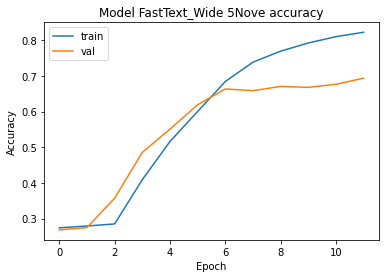

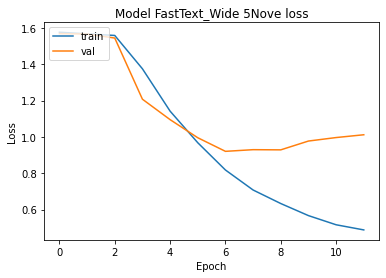

In [164]:
plt.plot(hist_fast_org_wide.history['accuracy'])
plt.plot(hist_fast_org_wide.history['val_accuracy'])
plt.title('Model FastText_Wide 5Nove accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_fast_org_wide.history['loss'])
plt.plot(hist_fast_org_wide.history['val_loss'])
plt.title('Model FastText_Wide 5Nove loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [100]:
pred_fast_org_wide = model_fast_org_wide.predict(test_padded)
sample_submission[['0','1','2','3','4']] = pred_fast_org_wide
sample_submission

,index,0,1,2,3,4
0,0,2.670747e-06,2.223150e-07,9.984823e-01,1.514559e-03,3.440777e-07
1,1,1.396762e-02,1.132298e-02,5.346874e-02,9.203603e-01,8.803526e-04
2,2,9.999945e-01,3.344102e-06,2.581245e-13,2.428963e-16,2.152002e-06
3,3,5.848231e-05,2.298227e-07,7.816702e-02,9.217685e-01,5.677840e-06
4,4,5.781224e-01,2.874525e-01,2.957534e-02,2.606623e-02,7.878348e-02
...,...,...,...,...,...,...
19612,19612,2.177409e-04,9.977134e-01,6.609369e-06,2.062134e-03,1.855701e-08
19613,19613,9.814097e-06,5.183563e-11,1.695540e-05,6.015406e-13,9.999732e-01
19614,19614,4.115734e-05,9.999105e-01,4.347955e-08,4.833213e-05,1.266608e-10
19615,19615,1.044909e-07,9.999802e-01,2.756700e-10,1.966872e-05,8.840837e-15


In [101]:
model_fast_org_wide.save('/content/drive/MyDrive/Novelist_Classification/model/CNN/cnn_fast_org_wide.h5')


커널 사이즈 3,4,5를 각각 거친후 GlobalMaxPool1D 실행후 concat으로 합치기 <br>
FastText 작가 8명


In [109]:
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size_new, 100,weights = [FT_embedding_matrix_new], input_length=max_length)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

In [110]:
conv1_1 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1_1 = GlobalMaxPool1D()(conv1_1)
conv1_2 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1_2 = GlobalMaxPool1D()(conv1_2)
conv2_1 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool2_1 = GlobalMaxPool1D()(conv2_1)
conv2_2 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool2_2 = GlobalMaxPool1D()(conv2_2)
conv3_1 = Conv1D(filters=128, kernel_size=2, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool3_1 = GlobalMaxPool1D()(conv3_1)
conv3_2 = Conv1D(filters=128, kernel_size=2, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool3_2 = GlobalMaxPool1D()(conv3_2)

In [111]:
concat = concatenate([pool1_1,pool1_2 , pool2_1, pool2_2, pool3_1, pool3_2])
hidden = Dense(128, activation=tf.nn.relu)(concat)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(8, name='logits')(dropout_hidden)
predictions = Dense(8, activation=tf.nn.softmax)(logits)

In [112]:
model_fast_new_wide = Model(inputs=input_layer,outputs=predictions)
model_fast_new_wide.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [113]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
hist_fast_new_wide = model_fast_new_wide.fit(train_padded_new,y_train_new, epochs=EPOCH, verbose=2,validation_split=0.2,callbacks = [early_stopping])

Epoch 1/30
2081/2081 - 131s - loss: 2.0350 - accuracy: 0.1849 - val_loss: 1.9742 - val_accuracy: 0.2463
Epoch 2/30
2081/2081 - 129s - loss: 1.9037 - accuracy: 0.2612 - val_loss: 1.6014 - val_accuracy: 0.3813
Epoch 3/30
2081/2081 - 129s - loss: 1.5738 - accuracy: 0.3897 - val_loss: 1.3951 - val_accuracy: 0.4551
Epoch 4/30
2081/2081 - 129s - loss: 1.3659 - accuracy: 0.4726 - val_loss: 1.2828 - val_accuracy: 0.4950
Epoch 5/30
2081/2081 - 129s - loss: 1.2097 - accuracy: 0.5323 - val_loss: 1.1744 - val_accuracy: 0.5470
Epoch 6/30
2081/2081 - 129s - loss: 1.0857 - accuracy: 0.5794 - val_loss: 1.1480 - val_accuracy: 0.5481
Epoch 7/30
2081/2081 - 129s - loss: 0.9744 - accuracy: 0.6228 - val_loss: 1.1414 - val_accuracy: 0.5571
Epoch 8/30
2081/2081 - 129s - loss: 0.8938 - accuracy: 0.6535 - val_loss: 1.0765 - val_accuracy: 0.5972
Epoch 9/30
2081/2081 - 129s - loss: 0.8364 - accuracy: 0.6752 - val_loss: 1.0897 - val_accuracy: 0.5910
Epoch 10/30
2081/2081 - 129s - loss: 0.7916 - accuracy: 0.6928 -

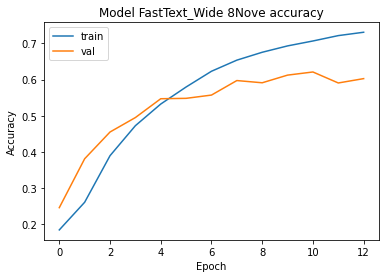

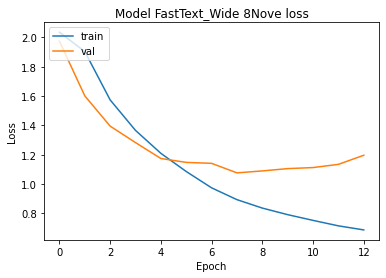

In [165]:
plt.plot(hist_fast_new_wide.history['accuracy'])
plt.plot(hist_fast_new_wide.history['val_accuracy'])
plt.title('Model FastText_Wide 8Nove accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_fast_new_wide.history['loss'])
plt.plot(hist_fast_new_wide.history['val_loss'])
plt.title('Model FastText_Wide 8Nove loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [115]:
pred_fast_new_wide = model_fast_new_wide.predict(test_padded_new)
sample_submission_new[['0','1','2','3','4','5','6','7']] = pred_fast_new_wide
sample_submission_new

,index,0,1,2,3,4,5,6,7
0,0,2.421407e-10,1.774742e-03,3.515092e-14,2.040225e-13,4.949230e-15,9.982243e-01,1.883674e-07,7.568285e-07
1,1,4.997990e-04,7.204313e-01,1.137136e-04,4.017718e-04,3.210833e-05,2.775736e-01,1.012108e-04,8.464790e-04
2,2,3.783545e-06,7.886993e-02,8.693059e-08,5.811464e-07,2.001867e-08,9.209743e-01,2.899693e-05,1.222867e-04
3,3,6.758197e-06,4.023818e-02,1.554582e-08,9.315421e-08,8.969902e-09,9.594766e-01,1.516922e-05,2.631960e-04
4,4,7.955160e-02,1.710955e-03,2.340851e-07,3.229059e-07,7.568905e-06,1.076489e-01,3.269935e-04,8.107533e-01
...,...,...,...,...,...,...,...,...,...
27313,27313,5.927758e-09,9.999990e-01,8.989287e-13,5.767878e-09,4.519442e-13,9.650788e-07,1.095950e-20,1.121884e-13
27314,27314,6.485359e-03,1.705198e-09,1.969211e-04,1.412994e-07,9.883251e-01,2.109648e-11,5.197469e-05,4.940541e-03
27315,27315,7.050815e-10,9.999852e-01,1.265409e-13,3.516233e-10,3.744131e-14,1.472544e-05,1.995673e-19,2.800826e-13
27316,27316,9.053002e-03,9.905820e-01,2.614665e-05,2.978520e-04,3.234366e-05,8.238721e-06,3.447241e-13,3.379680e-07


In [116]:
model_fast_new_wide.save('/content/drive/MyDrive/Novelist_Classification/model/CNN/cnn_fast_new_wide.h5')

커널 사이즈 3,4,5를 각각 거친후 GlobalMaxPool1D 실행후 concat으로 합치기<br>
glove 작가 5명


In [117]:
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size, 50,weights = [g_embedding_matrix], input_length=max_length)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

In [118]:
conv1_1 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1_1 = GlobalMaxPool1D()(conv1_1)
conv1_2 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1_2 = GlobalMaxPool1D()(conv1_2)
conv2_1 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool2_1 = GlobalMaxPool1D()(conv2_1)
conv2_2 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool2_2 = GlobalMaxPool1D()(conv2_2)
conv3_1 = Conv1D(filters=128, kernel_size=2, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool3_1 = GlobalMaxPool1D()(conv3_1)
conv3_2 = Conv1D(filters=128, kernel_size=2, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool3_2 = GlobalMaxPool1D()(conv3_2)

In [119]:
concat = concatenate([pool1_1,pool1_2 , pool2_1, pool2_2, pool3_1, pool3_2])
hidden = Dense(128, activation=tf.nn.relu)(concat)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(5, name='logits')(dropout_hidden)
predictions = Dense(5, activation=tf.nn.softmax)(logits)

In [120]:
model_glove_org_wide = Model(inputs=input_layer,outputs=predictions)
model_glove_org_wide.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [121]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
hist_glove_org_wide = model_glove_org_wide.fit(train_padded,y_train, epochs=EPOCH, verbose=2,validation_split=0.2,callbacks = [early_stopping])

Epoch 1/30
1372/1372 - 36s - loss: 1.5276 - accuracy: 0.3169 - val_loss: 1.3486 - val_accuracy: 0.4393
Epoch 2/30
1372/1372 - 35s - loss: 1.3563 - accuracy: 0.4302 - val_loss: 1.1981 - val_accuracy: 0.5282
Epoch 3/30
1372/1372 - 34s - loss: 1.2489 - accuracy: 0.4845 - val_loss: 1.1008 - val_accuracy: 0.5594
Epoch 4/30
1372/1372 - 34s - loss: 1.1729 - accuracy: 0.5297 - val_loss: 1.0064 - val_accuracy: 0.6164
Epoch 5/30
1372/1372 - 34s - loss: 1.1115 - accuracy: 0.5574 - val_loss: 0.9471 - val_accuracy: 0.6388
Epoch 6/30
1372/1372 - 35s - loss: 1.0569 - accuracy: 0.5877 - val_loss: 0.8984 - val_accuracy: 0.6679
Epoch 7/30
1372/1372 - 34s - loss: 1.0027 - accuracy: 0.6115 - val_loss: 0.8868 - val_accuracy: 0.6678
Epoch 8/30
1372/1372 - 34s - loss: 0.9484 - accuracy: 0.6332 - val_loss: 0.8443 - val_accuracy: 0.6783
Epoch 9/30
1372/1372 - 34s - loss: 0.9020 - accuracy: 0.6565 - val_loss: 0.8088 - val_accuracy: 0.7020
Epoch 10/30
1372/1372 - 35s - loss: 0.8663 - accuracy: 0.6722 - val_loss:

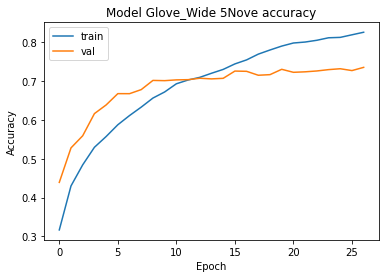

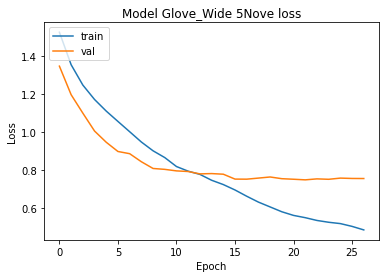

In [166]:
plt.plot(hist_glove_org_wide.history['accuracy'])
plt.plot(hist_glove_org_wide.history['val_accuracy'])
plt.title('Model Glove_Wide 5Nove accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_glove_org_wide.history['loss'])
plt.plot(hist_glove_org_wide.history['val_loss'])
plt.title('Model Glove_Wide 5Nove loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [123]:
pred_glove_org_wide = model_glove_org_wide.predict(test_padded)
sample_submission[['0','1','2','3','4']] = pred_glove_org_wide
sample_submission

,index,0,1,2,3,4
0,0,1.704678e-05,1.532790e-03,9.963019e-01,3.448855e-04,1.803338e-03
1,1,2.506628e-01,1.357672e-01,8.988760e-02,3.572778e-01,1.664045e-01
2,2,9.999975e-01,1.909478e-06,9.966928e-14,6.305808e-13,6.342267e-07
3,3,1.350293e-03,3.387095e-03,9.651414e-01,1.600135e-02,1.412002e-02
4,4,8.713756e-01,6.895933e-02,5.117011e-03,1.120823e-02,4.333976e-02
...,...,...,...,...,...,...
19612,19612,2.760934e-05,9.999484e-01,1.018922e-07,2.383867e-05,9.821703e-09
19613,19613,7.130595e-05,2.311376e-07,2.299235e-04,3.848361e-06,9.996947e-01
19614,19614,2.582285e-07,9.999993e-01,1.035109e-09,5.102004e-07,7.664352e-12
19615,19615,1.939461e-09,1.000000e+00,9.194550e-11,3.790711e-08,2.250563e-14


In [124]:
model_glove_org_wide.save('/content/drive/MyDrive/Novelist_Classification/model/CNN/cnn_glove_org_wide.h5')

glove_wide <br>
작가 8명


In [150]:
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size_new+1, 50,weights = [g_embedding_matrix_new], input_length=max_length)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

In [151]:
conv1_1 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1_1 = GlobalMaxPool1D()(conv1_1)
conv1_2 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1_2 = GlobalMaxPool1D()(conv1_2)
conv2_1 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool2_1 = GlobalMaxPool1D()(conv2_1)
conv2_2 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool2_2 = GlobalMaxPool1D()(conv2_2)
conv3_1 = Conv1D(filters=128, kernel_size=2, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool3_1 = GlobalMaxPool1D()(conv3_1)
conv3_2 = Conv1D(filters=128, kernel_size=2, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool3_2 = GlobalMaxPool1D()(conv3_2)

In [152]:
concat = concatenate([pool1_1,pool1_2 , pool2_1, pool2_2, pool3_1, pool3_2])
hidden = Dense(128, activation=tf.nn.relu)(concat)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(8, name='logits')(dropout_hidden)
predictions = Dense(8, activation=tf.nn.softmax)(logits)

In [153]:
model_glove_new_wide_200 = Model(inputs=input_layer,outputs=predictions)
model_glove_new_wide_200.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [154]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
hist_glove_new_wide_200 = model_glove_new_wide_200.fit(train_padded_new,y_train_new, epochs=200, verbose=2,validation_split=0.2,callbacks = [early_stopping])

Epoch 1/200
2081/2081 - 68s - loss: 2.0029 - accuracy: 0.1881 - val_loss: 1.8793 - val_accuracy: 0.2508
Epoch 2/200
2081/2081 - 66s - loss: 1.9496 - accuracy: 0.2180 - val_loss: 1.8477 - val_accuracy: 0.2757
Epoch 3/200
2081/2081 - 65s - loss: 1.9263 - accuracy: 0.2299 - val_loss: 1.8222 - val_accuracy: 0.2862
Epoch 4/200
2081/2081 - 65s - loss: 1.9089 - accuracy: 0.2411 - val_loss: 1.7524 - val_accuracy: 0.3261
Epoch 5/200
2081/2081 - 66s - loss: 1.8927 - accuracy: 0.2441 - val_loss: 1.7421 - val_accuracy: 0.3277
Epoch 6/200
2081/2081 - 65s - loss: 1.8795 - accuracy: 0.2478 - val_loss: 1.7187 - val_accuracy: 0.3380
Epoch 7/200
2081/2081 - 65s - loss: 1.8675 - accuracy: 0.2482 - val_loss: 1.6886 - val_accuracy: 0.3496
Epoch 8/200
2081/2081 - 64s - loss: 1.8537 - accuracy: 0.2507 - val_loss: 1.6665 - val_accuracy: 0.3537
Epoch 9/200
2081/2081 - 64s - loss: 1.8490 - accuracy: 0.2508 - val_loss: 1.6283 - val_accuracy: 0.3565
Epoch 10/200
2081/2081 - 64s - loss: 1.8393 - accuracy: 0.2466 -

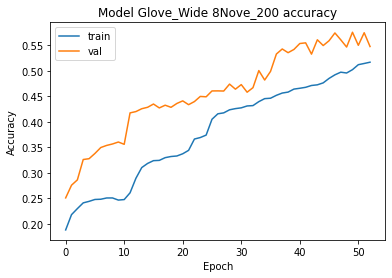

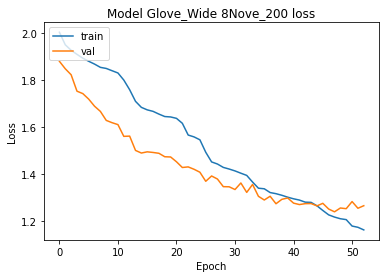

In [167]:
plt.plot(hist_glove_new_wide_200.history['accuracy'])
plt.plot(hist_glove_new_wide_200.history['val_accuracy'])
plt.title('Model Glove_Wide 8Nove_200 accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_glove_new_wide_200.history['loss'])
plt.plot(hist_glove_new_wide_200.history['val_loss'])
plt.title('Model Glove_Wide 8Nove_200 loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [168]:
pred_glove_new_wide_200 = model_glove_new_wide_200.predict(test_padded_new)
sample_submission_new[['0','1','2','3','4','5','6','7']] = pred_glove_new_wide_200
sample_submission_new

,index,0,1,2,3,4,5,6,7
0,0,2.161727e-01,1.267584e-01,0.045671,0.020911,0.015699,2.976650e-01,0.011537,2.655863e-01
1,1,2.161727e-01,1.267584e-01,0.045671,0.020911,0.015699,2.976650e-01,0.011537,2.655863e-01
2,2,2.161727e-01,1.267584e-01,0.045671,0.020911,0.015699,2.976650e-01,0.011537,2.655863e-01
3,3,2.161727e-01,1.267584e-01,0.045671,0.020911,0.015699,2.976650e-01,0.011537,2.655863e-01
4,4,2.161727e-01,1.267584e-01,0.045671,0.020911,0.015699,2.976650e-01,0.011537,2.655863e-01
...,...,...,...,...,...,...,...,...,...
27313,27313,4.349017e-01,3.355178e-01,0.096146,0.092918,0.038865,1.397998e-03,0.000047,2.053882e-04
27314,27314,3.014250e-07,1.802749e-08,0.341852,0.002714,0.285231,1.217275e-10,0.370202,8.289832e-07
27315,27315,4.264104e-01,3.389772e-01,0.094838,0.099907,0.039085,6.784971e-04,0.000023,8.119737e-05
27316,27316,4.418367e-01,3.320038e-01,0.097191,0.087174,0.038641,2.607929e-03,0.000088,4.579088e-04


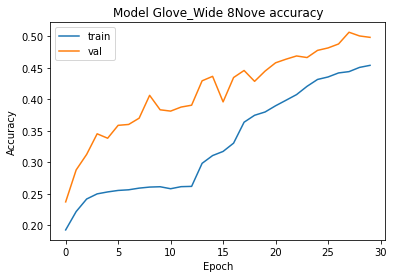

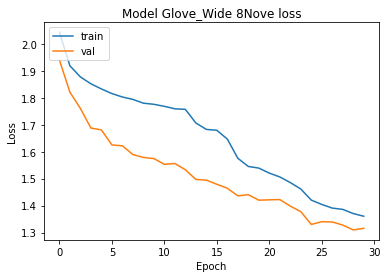

In [169]:
plt.plot(hist_glove_new_wide.history['accuracy'])
plt.plot(hist_glove_new_wide.history['val_accuracy'])
plt.title('Model Glove_Wide 8Nove accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_glove_new_wide.history['loss'])
plt.plot(hist_glove_new_wide.history['val_loss'])
plt.title('Model Glove_Wide 8Nove loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [131]:
pred_glove_new_wide = model_glove_new_wide.predict(test_padded_new)
sample_submission_new[['0','1','2','3','4','5','6','7']] = pred_glove_new_wide
sample_submission_new

,index,0,1,2,3,4,5,6,7
0,0,0.233701,0.101223,0.007502,0.004039,0.013262,0.298232,3.218981e-03,0.338822
1,1,0.225494,0.103773,0.012034,0.006532,0.018780,0.303036,5.837300e-03,0.324514
2,2,0.263890,0.085021,0.000678,0.000338,0.002253,0.252683,1.584233e-04,0.394979
3,3,0.258821,0.088645,0.001124,0.000567,0.003277,0.262442,2.980187e-04,0.384826
4,4,0.209753,0.105402,0.023767,0.013052,0.030810,0.304543,1.382448e-02,0.298849
...,...,...,...,...,...,...,...,...,...
27313,27313,0.597874,0.399659,0.000180,0.000277,0.001334,0.000019,2.396208e-09,0.000657
27314,27314,0.068050,0.021483,0.243693,0.034834,0.186231,0.024011,3.544802e-01,0.067219
27315,27315,0.501480,0.487091,0.001596,0.002656,0.006766,0.000014,2.549001e-08,0.000397
27316,27316,0.698988,0.265148,0.000982,0.000744,0.004311,0.003098,2.070590e-06,0.026726


In [132]:
model_glove_new_wide.save('/content/drive/MyDrive/Novelist_Classification/model/CNN/cnn_glove_new_wide.h5')

# 그래프

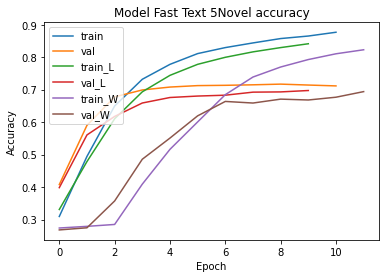

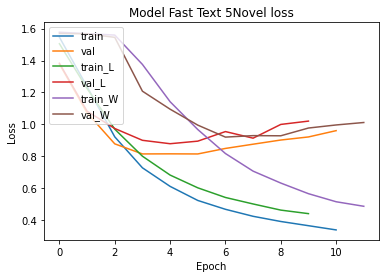

In [146]:
plt.plot(hist_fast_org.history['accuracy'])
plt.plot(hist_fast_org.history['val_accuracy'])
plt.plot(hist_fast_org_long.history['accuracy'])
plt.plot(hist_fast_org_long.history['val_accuracy'])
plt.plot(hist_fast_org_wide.history['accuracy'])
plt.plot(hist_fast_org_wide.history['val_accuracy'])
plt.title('Model Fast Text 5Novel accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val','train_L','val_L','train_W','val_W'], loc='upper left')
plt.show()

plt.plot(hist_fast_org.history['loss'])
plt.plot(hist_fast_org.history['val_loss'])
plt.plot(hist_fast_org_long.history['loss'])
plt.plot(hist_fast_org_long.history['val_loss'])
plt.plot(hist_fast_org_wide.history['loss'])
plt.plot(hist_fast_org_wide.history['val_loss'])
plt.title('Model Fast Text 5Novel loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val','train_L','val_L','train_W','val_W'], loc='upper left')
plt.show()


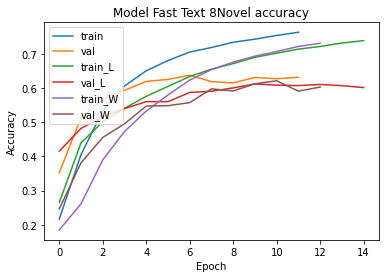

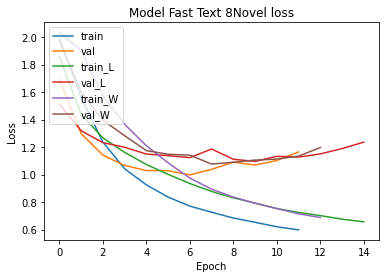

In [147]:
plt.plot(hist_fast_new.history['accuracy'])
plt.plot(hist_fast_new.history['val_accuracy'])
plt.plot(hist_fast_new_long.history['accuracy'])
plt.plot(hist_fast_new_long.history['val_accuracy'])
plt.plot(hist_fast_new_wide.history['accuracy'])
plt.plot(hist_fast_new_wide.history['val_accuracy'])
plt.title('Model Fast Text 8Novel accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val','train_L','val_L','train_W','val_W'], loc='upper left')
plt.show()

plt.plot(hist_fast_new.history['loss'])
plt.plot(hist_fast_new.history['val_loss'])
plt.plot(hist_fast_new_long.history['loss'])
plt.plot(hist_fast_new_long.history['val_loss'])
plt.plot(hist_fast_new_wide.history['loss'])
plt.plot(hist_fast_new_wide.history['val_loss'])
plt.title('Model Fast Text 8Novel loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val','train_L','val_L','train_W','val_W'], loc='upper left')
plt.show()


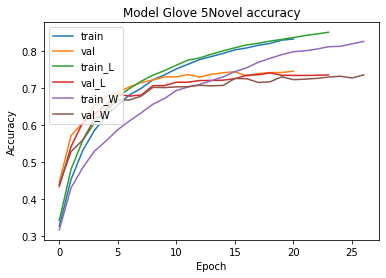

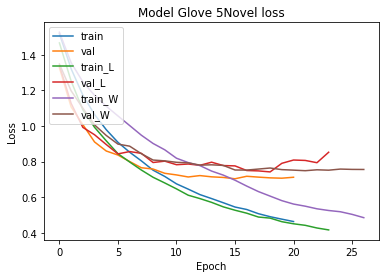

In [170]:
plt.plot(hist_glove_org.history['accuracy'])
plt.plot(hist_glove_org.history['val_accuracy'])
plt.plot(hist_glove_org_long.history['accuracy'])
plt.plot(hist_glove_org_long.history['val_accuracy'])
plt.plot(hist_glove_org_wide.history['accuracy'])
plt.plot(hist_glove_org_wide.history['val_accuracy'])
plt.title('Model Glove 5Novel accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val','train_L','val_L','train_W','val_W'], loc='upper left')
plt.show()

plt.plot(hist_glove_org.history['loss'])
plt.plot(hist_glove_org.history['val_loss'])
plt.plot(hist_glove_org_long.history['loss'])
plt.plot(hist_glove_org_long.history['val_loss'])
plt.plot(hist_glove_org_wide.history['loss'])
plt.plot(hist_glove_org_wide.history['val_loss'])
plt.title('Model Glove 5Novel loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val','train_L','val_L','train_W','val_W'], loc='upper left')
plt.show()


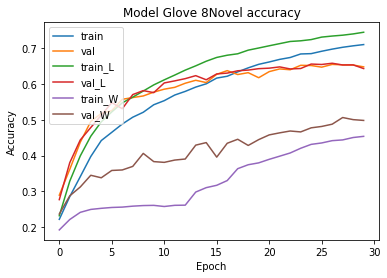

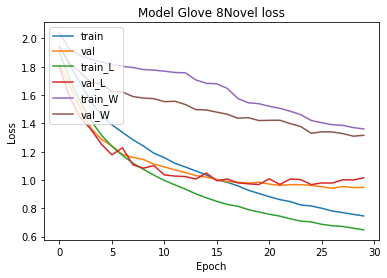

In [171]:
plt.plot(hist_glove_new.history['accuracy'])
plt.plot(hist_glove_new.history['val_accuracy'])
plt.plot(hist_glove_new_long.history['accuracy'])
plt.plot(hist_glove_new_long.history['val_accuracy'])
plt.plot(hist_glove_new_wide.history['accuracy'])
plt.plot(hist_glove_new_wide.history['val_accuracy'])
plt.title('Model Glove 8Novel accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val','train_L','val_L','train_W','val_W'], loc='upper left')
plt.show()

plt.plot(hist_glove_new.history['loss'])
plt.plot(hist_glove_new.history['val_loss'])
plt.plot(hist_glove_new_long.history['loss'])
plt.plot(hist_glove_new_long.history['val_loss'])
plt.plot(hist_glove_new_wide.history['loss'])
plt.plot(hist_glove_new_wide.history['val_loss'])
plt.title('Model Glove 8Novel loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val','train_L','val_L','train_W','val_W'], loc='upper left')
plt.show()
